# Interacting with a finite-strain MFront behaviour

*Author: Jeremy Bleyer, ENPC*

## Objectives 

This notebook shows how we can use the Python [`MFrontGenericSupportInterface`](https://thelfer.github.io/mgis/web/index.html) to interact with a finite-strain mechanical behaviour compiled with MFront.

The corresponding behaviour is a finite-strain elastoplastic behaviour formulated in the framework of logarithmic strains (Hencky strain measure). Such finite-strain behaviours offer the advantage of using the same implementation as the small-strain case, except that strains are now formulated with Hencky strain measures ($\boldsymbol{H}=\boldsymbol{H}^\text{e}+\boldsymbol{H}^\text{p}$) instead of the linearized strain ($\boldsymbol{\varepsilon}=\boldsymbol{\varepsilon}^\text{e}+\boldsymbol{\varepsilon}^\text{p}$). The small-strain elastoplastic component is  the same as in the companion [small-strain demo](mgis_small_strain.ipynb).

The following implementation shows:
- how to read information from the compiled behaviour, such as the declared internal state variable names or material properties
- how to ask for specific stress measures and tangent operator forms
- how to set up material properties
- how to impose values for the deformation gradient, call the behaviour integration for a batch of quadrature points and update the mechanical state for subsequent time steps
- how to locally solve a non-linear system involving the computed tangent operator

## Problem setting

Similarly to the small-strain demo, we aim to solve for a uniaxial stress state along the $x$ direction, while controlling the imposed horizontal strain $\epsilon$. In finite-strain the main deformation measure is the deformation gradient $\boldsymbol{F}$. We thus impose an horizontal elongation $F_{xx}=1+\epsilon$, the 8 ($\boldsymbol{F}$ is non-symmetric) remaining components $F_{ij}$ are considered as unknowns and we want to solve the following problem at a given imposed horizontal strain: Find $\boldsymbol{F}$ such that
$$
\boldsymbol{R}(\boldsymbol{F}) = \begin{Bmatrix}
F_{xx} - 1-\epsilon \\
P_{yy}(\boldsymbol{F}) \\
P_{zz}(\boldsymbol{F}) \\
P_{xy}(\boldsymbol{F}) \\
P_{yx}(\boldsymbol{F}) \\
P_{xz}(\boldsymbol{F}) \\
P_{zx}(\boldsymbol{F}) \\
P_{yz}(\boldsymbol{F}) \\
P_{zy}(\boldsymbol{F})
\end{Bmatrix} = 0
$$
where $\boldsymbol{P}$ is here the 1st Piola-Kirchhoff stress. 

To solve this non-linear problem, we write a custom Newton-Raphson method which will involve the following $9x9$ jacobian:
$$
\boldsymbol{J} = \dfrac{\partial \boldsymbol{R}}{\partial \boldsymbol{F}} = \begin{bmatrix} 
\begin{bmatrix} 1 & 0 & \ldots & 0\end{bmatrix}\\
\bar{C}_\text{tang}
\end{bmatrix}
$$
where $\bar{\boldsymbol{C}}_\text{tang}$ is the sub-matrix obtained by removing the first row from the tangent stiffness $\boldsymbol{C}_\text{tang} = \dfrac{\partial \boldsymbol{P}}{\partial \boldsymbol{F}}$.


Note that $\boldsymbol{P}$ is also non-symmetric. However, the formulated behaviour will necessary satisfy balance of angular momentum and will produce stress states satisfying $\boldsymbol{P} = \boldsymbol{F}\boldsymbol{S}$ where $\boldsymbol{S}$ is the 2nd Piola-Kirchhoff stress with $\boldsymbol{S}$ being symmetric. Hence, by construction $\boldsymbol{P}\boldsymbol{F}^{\text{T}}=\boldsymbol{F}\boldsymbol{P}^{\text{T}}$. This property introduces linearly dependent equation in the above nonlinear system, resulting in a singular $9x9$ Jacobian matrix. To circumvent this issue, we will simply solve the Newton iterations in the least-square sense.


In the following, we will compute the behaviour integration and the above non-linear resolution for a batch of `ngauss` points for illustration purposes. For simplicity, we will impose the same strain $\epsilon$ for all points, yielding the same response for all points but different strain values could also be considered for the different material points.

## Implementation

### Compiling the behaviour

First, we call the `mfront --obuild --interface=generic LogarithmicStrainPlasticity.mfront` command to compile the MFront behaviour. This should only be done once and for all if the behaviour implementation does not change anymore.

Shared libraries are then stored in the `src/libBehaviour.so` file which will be used to load the behaviour.

In [1]:
import subprocess
import numpy as np
import mgis.behaviour as mgis_bv


behaviour_name = "LogarithmicStrainPlasticity"
subprocess.call(["mfront", "--obuild", "--interface=generic", behaviour_name+".mfront"])

lib_path = "src/libBehaviour.so"

Treating target : all
The following library has been built :
- libBehaviour.so :  LogarithmicStrainPlasticity_AxisymmetricalGeneralisedPlaneStrain LogarithmicStrainPlasticity_Axisymmetrical LogarithmicStrainPlasticity_PlaneStrain LogarithmicStrainPlasticity_GeneralisedPlaneStrain LogarithmicStrainPlasticity_Tridimensional SmallStrainPlasticity_AxisymmetricalGeneralisedPlaneStrain SmallStrainPlasticity_Axisymmetrical SmallStrainPlasticity_PlaneStrain SmallStrainPlasticity_GeneralisedPlaneStrain SmallStrainPlasticity_Tridimensional


### Loading the behaviour

We first need to choose the modeling hypothesis. Here, we will work with 3D states and thus choose the `Tridimensional` hypothesis. Behaviours are loaded differently depending on whether we work with a small or finite-strain setting. We use the `isStandardFiniteStrainBehaviour` function to check whether the behaviour is finite strain or not. For the present finite-strain case, we can specify options asking which stress measure we want the behaviour to return, we can for instance choose the Cauchy (`CAUCHY`) stress $\boldsymbol{\sigma}$, the 1st Piola-Kirchhoff stress (`PK1`) $\boldsymbol{P}$ or the 2nd Piola-Kirchhoff stress (`PK2`) $\boldsymbol{S}$. We choose the PK1 stress $\boldsymbol{P}$ here. SImilarly, we can ask for specific variants of the tangent operators such as:
$$
\begin{align*}
\texttt{DCAUCHY\_DF}/\texttt{DSIG\_DF}:\qquad & \dfrac{\partial\boldsymbol{\sigma}}{\partial \boldsymbol{F}}\\
\texttt{DPK1\_DF}:\qquad & \dfrac{\partial\boldsymbol{P}}{\partial \boldsymbol{F}}\\
\texttt{DS\_DEGL}:\qquad & \dfrac{\partial\boldsymbol{S}}{\partial \boldsymbol{E}^\text{GL}}\\
\texttt{DTAU\_DDF}:\qquad & \dfrac{\partial\boldsymbol{\tau}}{\partial \boldsymbol{D}}\\
\end{align*}
$$
where $\boldsymbol{E}^\text{GL}$ is the Green-Lagrange strain, $\boldsymbol{\tau}$ the Kirchhoff stress and $\Delta\,\boldsymbol{F}$$ is given by $\left.\boldsymbol{F}\right|_{t+dt}\,\cdot\,\left.\boldsymbol{F}\right|_{t}^{-1}$$.


In [2]:
hypothesis = mgis_bv.Hypothesis.Tridimensional

is_finite_strain = mgis_bv.isStandardFiniteStrainBehaviour(lib_path, behaviour_name)
if is_finite_strain:
    print("Finite strain behaviour detected.")
    bopts = mgis_bv.FiniteStrainBehaviourOptions()
    bopts.stress_measure = mgis_bv.FiniteStrainBehaviourOptionsStressMeasure.PK1
    bopts.tangent_operator = (
        mgis_bv.FiniteStrainBehaviourOptionsTangentOperator.DPK1_DF
    )
    behaviour = mgis_bv.load(bopts, lib_path, behaviour_name, hypothesis)
else:
    print("Small strain behaviour detected.")
    behaviour = mgis_bv.load(lib_path, behaviour_name, hypothesis)

Finite strain behaviour detected.


The `Behaviour` object now contains several information about the behaviour implementation such as names and types of gradients and thermodynamic forces and external or internal state variables. Here, we work with a purely mechanical behaviour so that gradients consist only of the total deformation gradient `DeformationGradient`. The resulting thermodynamic stress is `FirstPiolaKirchhoffStress`. By default, `Temperature` is always declared as an external state variable by MFront. Finally, since we are dealing with an elastoplastic behaviour with isotropic hardening, the internal state variables are the `ElasticStrain` and the `EquivalentPlasticStrain`. The former is a symmetric tensor whereas the latter is only a scalar.

In [ ]:
print("Kinematic type:", behaviour.getKinematic())
print("Gradient names:",[s.name for s in behaviour.gradients])
print("Thermodynamic forces names:", [s.name for s in behaviour.thermodynamic_forces])

print("External state variable names:",  [s.name for s in behaviour.external_state_variables])
print(
    "Internal state variable names:",
    [s.name for s in behaviour.internal_state_variables],
)
print(
    "Internal state variable types:",
    [s.type for s in behaviour.internal_state_variables],
)

Kinematic type: F_CAUCHY
Gradient names: ['DeformationGradient']
Thermodynamic forces names: ['FirstPiolaKirchhoffStress']
External state variable names: ['Temperature']
Internal state variable names: ['ElasticStrain', 'EquivalentPlasticStrain']
Internal state variable types: [mgis.behaviour.VariableType.STENSOR, mgis.behaviour.VariableType.SCALAR]


The size of these different quantities can be checked. Non-symmetric tensors in 3D are represented here as arrays of size 9, see [Tensors in MFront](https://thelfer.github.io/tfel/web/tensors.html).

In [ ]:
for s in behaviour.gradients + behaviour.thermodynamic_forces + behaviour.internal_state_variables: 
    print(f"{s.name} is of size {mgis_bv.getVariableSize(s, hypothesis)}")

DeformationGradient is of size 9
FirstPiolaKirchhoffStress is of size 9
ElasticStrain is of size 6
EquivalentPlasticStrain is of size 1


For more complex behaviours, different "blocks" of tangent operators can be declared and computed. The names of the tangent blocks can be retrieved as shown below. Here, we have a simple mechanical behaviour so that the only tangent operator is the tangent stiffness $\boldsymbol{C}_\text{tang} = \dfrac{\partial \boldsymbol{P}}{\partial \boldsymbol{F}}$, as specified earlier.

In [5]:
print(
    "Tangent operator block names:",
    [f"d{s[0].name}_d{s[1].name}" for s in behaviour.tangent_operator_blocks],
)

Tangent operator block names: ['dFirstPiolaKirchhoffStress_dDeformationGradient']


Finally, names of material properties can also be retrieved easily as follows:

In [6]:
print(
    "Material property names:",
    [s.name for s in behaviour.material_properties],
)

Material property names: ['InitialYieldStress', 'FinalYieldStress', 'HardeningCoefficient']


Other informations such as behaviour material symmetry or predefined parameters can also be obtained as follows:

In [7]:
print(behaviour.symmetry)
print(behaviour.parameters)

Isotropic
['epsilon', 'theta', 'YoungModulus', 'PoissonRatio', 'RelativeValueForTheEquivalentStressLowerBoundDefinition', 'minimal_time_step_scaling_factor', 'maximal_time_step_scaling_factor', 'numerical_jacobian_epsilon']


### Setting up the material data manager

The material data manager will be the data structure which will hold the information about the mechanical state and tangent operator for a single or a batch of integration points during a given time step. We first set up the data manager by declaring the number of integration points we want to handle.

In [8]:
ngauss = 3
data = mgis_bv.MaterialDataManager(behaviour, ngauss)

Values at the beginning of the time step will be stored in `data.s0`. This object is a `StateManager` which holds values of the gradients, thermodynamic forces and internal state variables. A similar one is stored in `data.s1` which will hold values at the end of the current time step, once behaviour integration has been performed. Here, by default, `DeformationGradient` is initialized with the identity tensor, all other variables at initialized at zero. We see below that `data.s0.gradients` is of shape `ngauss x 9` corresponding to the 9 components of the `ngauss` integration points.

In [9]:
print("Gradients:")
print("  Beginning of time step:\n", data.s0.gradients)
print("  End of time step:\n", data.s1.gradients)

print("Thermodynamic forces:")
print("  Beginning of time step:\n", data.s0.thermodynamic_forces)
print("  End of time step:\n", data.s1.thermodynamic_forces)

Gradients:
  Beginning of time step:
 [[1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0.]]
  End of time step:
 [[1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0.]]
Thermodynamic forces:
  Beginning of time step:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  End of time step:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Conversely, internal state variables are of shape `ngauss x 7` with components of `ElasticStrain` and `EquivalentPlasticStrain` being concatenated.

In [10]:
print("Internal state variables:")
print("  Beginning of time step:\n", data.s0.internal_state_variables)
print("  End of time step:\n", data.s1.internal_state_variables)

Internal state variables:
  Beginning of time step:
 [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
  End of time step:
 [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


### Declare material properties

In order to perform the behaviour integration, we need to declare the values for the material properties which are yet unspecified. We also need to declare the value of the temperature, although it is not used in practice. Note that we can declare different values at the beginning and at the end of the time step, although here we use the same values. Finally, we would also apply different values for the different integration points, if needed.

In [11]:
for state_manager in [data.s0, data.s1]:
    mgis_bv.setMaterialProperty(state_manager, "InitialYieldStress", 250e6)
    mgis_bv.setMaterialProperty(state_manager, "FinalYieldStress", 400e6)
    mgis_bv.setMaterialProperty(state_manager, "HardeningCoefficient", 1000.)

    mgis_bv.setExternalStateVariable(state_manager, "Temperature", 293.15)


### Defining the load-stepping scheme and the nonlinear system 

Below, we will impose a cyclic loading in terms of imposed horizontal strain. The value of the time step `dt` must be provided but is irrelevant here since we are dealing with a rate-independent behaviour.

In [12]:
# strain history
N = 20
eps_max = 3e-3
eps_list = np.concatenate((np.linspace(0, eps_max, N), np.linspace(eps_max, -eps_max, N), np.linspace(-eps_max, 0, N))*2)
lambda_list = 1 + eps_list

dt = 0

We now implement the expression of the global residual $\boldsymbol{R}$ and its jacobian $\boldsymbol{J}$. As stresses are expressed here in Pa, we use a scaling of `1e-9` to scale the stress components to values close to strain values.

In [13]:
stress_scaling = 1e-9
def residual(F, P, lamb):
    return np.concatenate((F[:, [0]] - lamb, P[:, 1:] * stress_scaling), axis=1)
def jacobian(F, P, Ct):
    Jac = np.zeros((ngauss, 9, 9))
    Jac[:,0,0] = 1
    Jac[:,1:,:] = Ct[:,1:,:]*stress_scaling
    return Jac

Integration of the material behaviour will be done by specifying that we want to compute the consistent tangent operator. 
We then implement the time stepping loop and the Newton-Raphson resolution. We recall that the values of the total deformation gradient are all assumed to be unknown and will be stored in the `F` variable, the latter being initialized with the deformation gradient values at the beginning of the time step. During a Newton-Raphson iteration, the deformation gradient values at the end of the time step are updated with the current value for `F`. Then, integration is performed using `mgis_bv.integrate`. Next, we retrieve the new value for the stress, stored in `P` and of the tangent operator, stored in `Ct`. We evaluate the residual $\boldsymbol{R}$ and perform the Newton correction to `eps` by solving the jacobian system (in the least square sense as discussed above). Finally, we report the horizontal stress value at the first integration point (we can check that all `ngauss` points give the same value). Before going to the next load step, the computed state must be updated using `mgis_bv.update(data)` which copies the computed state `s1` into `s0`.

In [14]:
integration_type = mgis_bv.IntegrationType.IntegrationWithConsistentTangentOperator
rtol = 1e-8
atol = 1e-8
niter_max = 20

Sxx = np.zeros_like(lambda_list)
for i, lamb_imposed in enumerate(lambda_list):
    F = np.copy(data.s0.gradients)
    P = np.copy(data.s0.thermodynamic_forces)

    # Newton-Raphson solve
    nres = 1
    nres0 = max(np.linalg.norm(residual(F, P, lamb_imposed),axis=1))
    niter = 0
    while (nres > max(atol, rtol*nres0)) and (niter < niter_max):
        data.s1.gradients[:] = F

        integration_status = mgis_bv.integrate(data, integration_type, dt, 0, data.n)
        assert integration_status > 0, "Behaviour integration has failed."

        P = data.s1.thermodynamic_forces
        Ct = data.K

        res = residual(F, P, lamb_imposed)
        nres = max(np.linalg.norm(res, axis=1))
        # print(f"Iteration {niter}, residual = {nres}")

        Jac = jacobian(F, P, Ct)
        for k in range(ngauss):
            F[k,:] += np.linalg.lstsq(Jac[k,:,:], -res[k,:])[0]

        niter += 1

    Sxx[i] = data.s1.thermodynamic_forces[0, 0]
    
    mgis_bv.update(data)

Plotting the horizontal stress strain evolutions shows the expected behaviour with a first yielding at 250 MPa and a saturation at 400 MPa in both tension and compression. Note that we do not observe much difference here compared to the small-strain case because of the chosen material properties and strain levels.

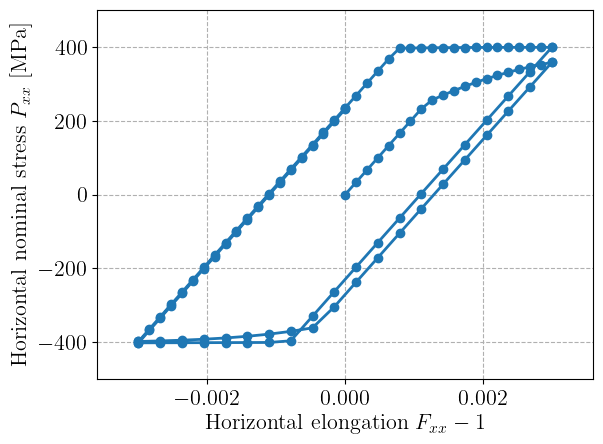

In [15]:
import matplotlib.pyplot as plt
plt.xlabel(r"Horizontal elongation $F_{xx}-1$")
plt.ylabel(r"Horizontal nominal stress $P_{xx}$ [MPa]")
plt.plot(eps_list, Sxx*1e-6, '-o')
plt.xlim(-1.2*eps_max, 1.2*eps_max)
plt.ylim(-500, 500)
plt.show()